In [1]:
import numpy as np
from torchvision.datasets import CocoDetection
import datetime
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import sys 
sys.path.append("/home/tyfei/cyroem")
import utils
import torch
import importlib 
import json
import modules
import data
importlib.reload(utils)
importlib.reload(modules)
import torchmetrics

import pycocotools.coco
import pycocotools.mask
import torchvision.transforms.v2 as transforms
from transformers import DetrConfig, DetrForObjectDetection, DetrImageProcessor, DetrForSegmentation, ConditionalDetrForObjectDetection,ConditionalDetrConfig,ConditionalDetrForSegmentation

/home/feity/anaconda3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#load model
model = utils.loadModel("/data/transformer_project/transforemer_model/train_data/training/results/conditional_detr_final/whole_continue_mask", "last.ckpt")
model = model.eval() 

Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([5]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model at stage  stage mask


/home/feity/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/feity/cryoem/utils.py:807: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded v

incompatible parameters []
finish loading parameters


/home/feity/cryoem/utils.py:845: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(path, checkpoint), map_location="cpu")["state_dict"]


incompatible parameters []
finish loading parameters


In [3]:
# read dataset and run stage 1
model.stage = "stage 1"
dataset = data.TestDataset("/data/transformer_project/transforemer_model/test_data/dxd20240920/tomo/24092002_9", norm="hist")
# dataset = modules.CocoDetection(
# "/data/transformer_project/transforemer_model/train_data/training/data/", 
# "/data/transformer_project/transforemer_model/train_data/training/data/annotations/sllt0039_9.pkl",
#                             is_npy=True, filter_class=[3, 4, 7, 12, 14], map_class={"3":0, "4":1, "7":2, "12":3, "14":4}, require_mask=True, transform=utils.getConstantTransform(), add_classname=True, norm="hist",filtermin=5
# )
retdict = utils.buildStage2(model, dataset, (800, 800), 0.05, has_none=False, empty=5)
graph = utils.convertStage2Dataset(retdict)

slice 0
obj_cnts: 150
slice 1
obj_cnts: 289
slice 2
obj_cnts: 371
slice 3
obj_cnts: 466
slice 4
obj_cnts: 544
slice 5
obj_cnts: 596
slice 6
obj_cnts: 622
slice 7
obj_cnts: 683
slice 8
obj_cnts: 765
slice 9
obj_cnts: 867
slice 10
obj_cnts: 1015
slice 11
obj_cnts: 1196
slice 12
obj_cnts: 1386
slice 13
obj_cnts: 1575
slice 14
obj_cnts: 1786
slice 15
obj_cnts: 2030
slice 16
obj_cnts: 2289
slice 17
obj_cnts: 2566
slice 18
obj_cnts: 2839
slice 19
obj_cnts: 3113
slice 20
obj_cnts: 3390
slice 21
obj_cnts: 3661
slice 22
obj_cnts: 3934
slice 23
obj_cnts: 4205
slice 24
obj_cnts: 4467
slice 25
obj_cnts: 4715
slice 26
obj_cnts: 4951
slice 27
obj_cnts: 5196
slice 28
obj_cnts: 5439
slice 29
obj_cnts: 5678
slice 30
obj_cnts: 5920
slice 31
obj_cnts: 6149
slice 32
obj_cnts: 6367
slice 33
obj_cnts: 6593
slice 34
obj_cnts: 6818
slice 35
obj_cnts: 7027
slice 36
obj_cnts: 7242
slice 37
obj_cnts: 7452
slice 38
obj_cnts: 7660
slice 39
obj_cnts: 7848
slice 40
obj_cnts: 8041
slice 41
obj_cnts: 8225
slice 42
obj

In [8]:
graph

Data(x=[18380, 266], edge_index=[2, 742312], y=[18380], box_masks=[18380], boxes=[18380, 4], edge_label=[742312], sample_mapping=[18380])

In [9]:
# run stage 2
model.stage = "stage 2"
with torch.no_grad():
    res = model(graph.x, graph.edge_index)
z = graph.x[:, [0]]
prob = torch.softmax(res["predict"], 1)
pred_boxes = res["box"]

In [10]:
# concat results from different slices
df = torch.cat([z, pred_boxes, prob], 1)
df = df.detach().numpy()
df = pd.DataFrame(df, columns=["z", "x", "y", "w", "h", "ribo", "microtubule", "nucleus", "endoplasmic_reticulum_or_Golgi", "mitochondria", "None"])
subdf = df[["ribo", "microtubule", "nucleus", "endoplasmic_reticulum_or_Golgi", "mitochondria", "None"]]
v = subdf.values 
v = v > np.array([0.6, 0.5, 0.5, 0.5, 0.5, 1.2]) 
v = v.any(axis=1) 
df["max"] = subdf.max(axis=1)
df["largest"] = subdf.idxmax(axis=1)
df["prob"] = v    
df

,z,x,y,w,h,ribo,microtubule,nucleus,endoplasmic_reticulum_or_Golgi,mitochondria,None,max,largest,prob
0,0.00,0.882675,0.845110,0.020979,0.070286,0.022758,0.000048,0.000142,0.000125,2.243468e-05,0.976904,0.976904,None,False
1,0.00,0.612058,0.081893,0.013530,0.013560,0.014692,0.000004,0.000119,0.000108,4.407888e-06,0.985073,0.985073,None,False
2,0.00,0.911647,0.531861,0.042582,0.130140,0.015562,0.000011,0.001338,0.000122,4.068182e-05,0.982926,0.982926,None,False
3,0.00,0.106955,0.145206,0.012253,0.014218,0.078330,0.000021,0.000015,0.000016,1.774525e-07,0.921618,0.921618,None,False
4,0.00,0.732483,0.744612,0.012029,0.011899,0.030912,0.000010,0.000077,0.000033,2.047044e-06,0.968966,0.968966,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18375,0.99,0.934497,0.035410,0.045123,0.025056,0.144662,0.000116,0.000070,0.000287,1.371882e-06,0.854864,0.854864,None,False
18376,0.99,0.981585,0.804378,0.017811,0.017583,0.338820,0.000096,0.000010,0.000030,7.778742e-08,0.661044,0.661044,None,False
18377,0.99,0.924245,0.965047,0.018778,0.019943,0.641496,0.000069,0.000003,0.000016,7.628854e-09,0.358415,0.641496,ribo,True
18378,0.99,0.900412,0.841701,0.025281,0.024722,0.364875,0.000152,0.000011,0.000037,9.366326e-08,0.634924,0.634924,None,False


In [12]:
# run nms
nms = {"ribo":0.2, "microtubule":0.5, "nucleus":0.2, "endoplasmic_reticulum_or_Golgi":0.6, "mitochondria":0.2, "None":1.2}
alldfs = []
for i, subdf in df.groupby(["z", "largest"]):
    # print(subdf.head())
    if i[1] == "None":
        continue
    keep = utils.bbnms(nms[i[1]], utils.convertBoxes(torch.tensor(subdf[["x", "y", "w", "h"]].values)), torch.tensor(subdf["max"].values), subdf["largest"].values)
    # print(i, keep)
    subdf["bbnms"] = False
    subdf.loc[subdf.index[keep.numpy()], "bbnms"] = True
    alldfs.append(subdf)
df = pd.concat(alldfs)
df["final"] = df["bbnms"] & df["prob"]
df["final"].sum()

2825

In [13]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist, squareform

def get_labels(subdf):
    hdb = DBSCAN(min_samples=3, eps = 0.4, metric='precomputed')
    iou = utils.get_iou(subdf[["x", "y", "w", "h"]].values)
    iou = 1 - iou
    mask = subdf["z"].values 
    mask = mask[:, None] == mask[None, :]
    iou[mask] = 2
    mask = subdf["z"].values 
    dis_penalty = np.abs(mask[:, None] - mask[None, :])
    iou = iou + dis_penalty
    hdb.fit(iou)  
    return hdb.labels_
    #subdf["label"] = hdb.labels_
# np.unique(hdb.labels_).tolist()

In [14]:
# run dbscan
afterDBSCAN = [] 
for i, subdf in df.groupby(["largest"]):
    # print(subdf.head())
    if i == "None":
        continue
    subdf = subdf[subdf["final"]]
    if len(subdf) > 0:
        labels = get_labels(subdf)
        subdf["label"] = list(labels)
        afterDBSCAN.append(subdf)

/tmp/ipykernel_2454464/4209089231.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf["label"] = list(labels)
/tmp/ipykernel_2454464/4209089231.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf["label"] = list(labels)
/tmp/ipykernel_2454464/4209089231.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [15]:
df = pd.concat(afterDBSCAN)
np.unique(df["label"])

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [ ]:
# take one slice and visualize
take = 25
need = []
for i in retdict["sample_mapping"]:
    if retdict["sample_mapping"][i] == take and i in df.index:
        need.append(i)
        
img = retdict["images"][take]
subdf2 = df.loc[need]

""" if use dbscan results """
subdf2 = subdf2[subdf2["label"] != -1]
subdf2["label"] = subdf2["label"].astype("str")
# subdf2 = df[subdf2["final"]]
# 
# subdf2["label"] = subdf2["label"].astype("str")

/tmp/ipykernel_2454464/266363812.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bboxes = torch.tensor(bboxes)*torch.tensor([img.shape[1], img.shape[2], img.shape[1], img.shape[2]])
/home/feity/cryoem/utils.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image * 255).type(torch.uint8)
/home/feity/cryoem/utils.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  annotated_tensor = torch.tensor(annotated_tensor, dtype=torch.uint8)
/home/feity/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/utils

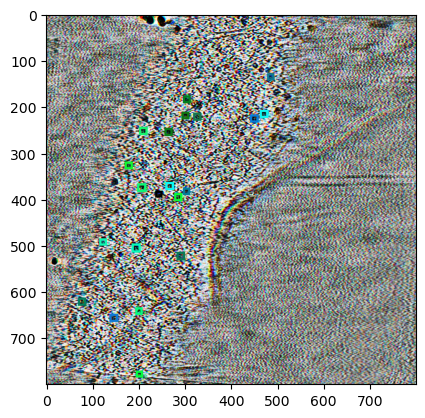

In [17]:
bboxes = subdf2[["x", "y", "w", "h"]].values
bboxes = utils.convertBoxes(torch.tensor(bboxes))
bboxes = torch.tensor(bboxes)*torch.tensor([img.shape[1], img.shape[2], img.shape[1], img.shape[2]])
# bboxes, img.shape
labels = {"bboxes": bboxes, "labels": subdf2["label"].values} 
utils.drawannotation(img, labels, font_size=100)

In [ ]:
# prepare for masks
model.stage = "stage mask"
model.eval()

In [ ]:
batch_size = 4
pv = img[None, :, :, :]
allmasks = []
for i in range(0, len(subdf2), batch_size):
    embed = res["embeddings"][subdf2.index[i:i+batch_size]].detach().cpu() 
    boxes = res["box"][subdf2.index[i:i+batch_size]].detach().cpu()
    pv_in = pv.repeat(embed.shape[0], 1, 1, 1)
    in_boxes = boxes.clone()
    # boxes = utils.convertBoxes(torch.tensor(boxes))
    # boxes = torch.tensor(boxes)*torch.tensor([img.shape[1], img.shape[2], img.shape[1], img.shape[2]])
    with torch.no_grad():
        outputs = model(pixel_values=pv_in.float(), stage_2_embeds=embed.float(), box=in_boxes) 
    
    # t = outputs[0]
    t = torch.sigmoid(outputs)
    t = t.squeeze(1).detach().cpu().numpy()
    allmasks.append(t)
allmasks = np.concatenate(allmasks, 0)

In [45]:
allmasks = np.concatenate(allmasks, 0)

In [47]:
len(subdf2)

21

In [18]:
pv = img[None, :, :, :].repeat(4, 1, 1, 1)
embed = res["embeddings"][subdf2.index[:4]].detach().cpu()

In [19]:
boxes = res["box"][subdf2.index[:4]].detach().cpu()
in_boxes = boxes.clone()
boxes = utils.convertBoxes(torch.tensor(boxes))
boxes = torch.tensor(boxes)*torch.tensor([img.shape[1], img.shape[2], img.shape[1], img.shape[2]])

/tmp/ipykernel_2454464/2115447526.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes = utils.convertBoxes(torch.tensor(boxes))
/tmp/ipykernel_2454464/2115447526.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes = torch.tensor(boxes)*torch.tensor([img.shape[1], img.shape[2], img.shape[1], img.shape[2]])


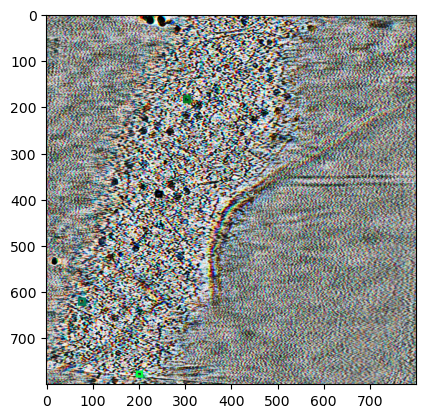

In [20]:
# bboxes = subdf2[["x", "y", "w", "h"]].values

labels = {"bboxes": boxes, "labels": ["test"]*4} 
# img[0] = img[1]
# img[2] = img[1]
utils.drawannotation(img, labels, font_size=100)

In [21]:
pv.shape, embed.shape, boxes.shape

(torch.Size([4, 3, 800, 800]), torch.Size([4, 256]), torch.Size([4, 4]))

In [22]:
model.stage = "stage mask"
model.eval()
with torch.no_grad():
    outputs = model(pixel_values=pv.float(), stage_2_embeds=embed.float(), box=in_boxes)

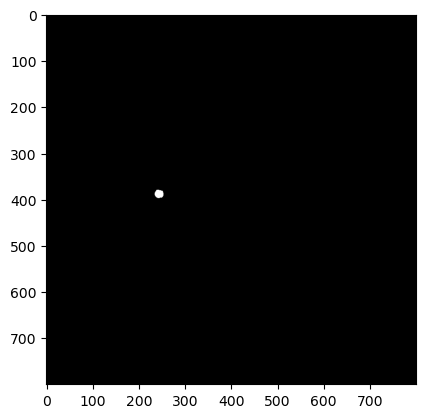

In [23]:
# show one mask
t = outputs[0]
t = torch.sigmoid(t)
plt.imshow(t > 0.3, cmap="gray")

masks


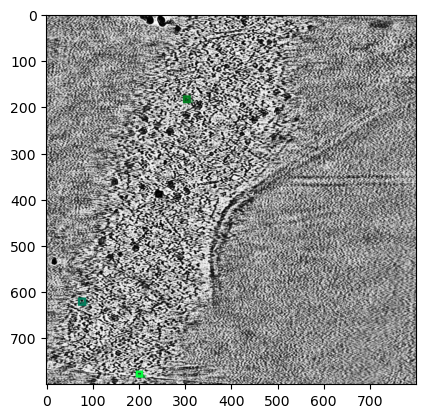

In [24]:
# bboxes = subdf2[["x", "y", "w", "h"]].values
t = outputs.detach().cpu()
labels = {"bboxes": boxes, "labels": ["test"]*4, "masks": t > 0.25, "class_labels":[0, 1, 2, 3]} 
img[0] = img[1]
img[2] = img[1]
utils.drawannotation(img, labels, font_size=100)

In [25]:
# show all four masks
THRES=0.3
q = torch.zeros((800, 800)) 
t = outputs[0].detach()
t = torch.sigmoid(t)
q = q + t > THRES
t = outputs[1].detach()
t = torch.sigmoid(t)
q = q + t > THRES
t = outputs[2].detach()
t = torch.sigmoid(t)
q = q + t > THRES
t = outputs[3].detach()
t = torch.sigmoid(t)
q = q + t > THRES
q = q.unsqueeze(0).repeat(3, 1, 1)  

masks


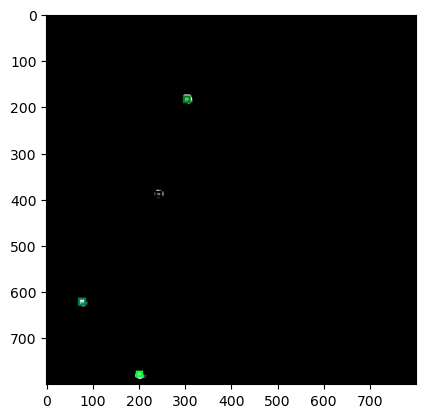

In [26]:
q = q.float()
utils.drawannotation(q, labels, font_size=100)